# Multiple Label Classification of Texts

The following notebook develops a model for sentiment analysis using a database of toxic comments, it identifies and predicts multiple labels each comment.

In [1]:
# Import libs
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [2]:
# Get dataset
toxic_comments = pd.read_csv("toxic_comments.csv")


The dataset used can be found [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview) (train.csv) and was renamed to toxic_comments.csv


In [3]:
# Visualize data
print(toxic_comments.shape)

toxic_comments.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# Remove empty records
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

In [5]:
# Print random comments' labels
print(toxic_comments["comment_text"][168])

You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


In [6]:
# Visualize the associated labels of the previous comment
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [7]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


<AxesSubplot:>

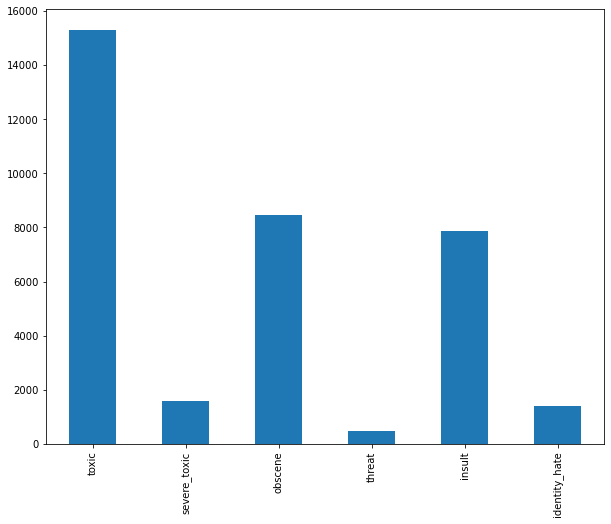

In [8]:
# Plot the data by label
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

In [34]:
# Function to clean the text
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [35]:
# Generate input and output sets
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [36]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [37]:
# Word embedding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [39]:
# GloVe implementation 
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

The GloVe embeddings file was downloaded from [here](https://www.kaggle.com/danielwillgeorge/glove6b100dtxt)

In [40]:
# Create the model
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [41]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________
None


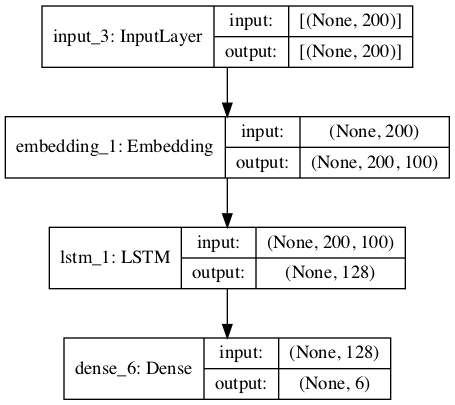

In [43]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='MultiClassification_model.png', show_shapes=True, show_layer_names=True)

In [44]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
798/798 [==============================] - 228s 283ms/step - loss: 0.1764 - acc: 0.8940 - val_loss: 0.1404 - val_acc: 0.9939
Epoch 2/5
798/798 [==============================] - 239s 299ms/step - loss: 0.1061 - acc: 0.9922 - val_loss: 0.0630 - val_acc: 0.9943
Epoch 3/5
798/798 [==============================] - 239s 299ms/step - loss: 0.0600 - acc: 0.9945 - val_loss: 0.0577 - val_acc: 0.9943
Epoch 4/5
798/798 [==============================] - 311s 390ms/step - loss: 0.0558 - acc: 0.9945 - val_loss: 0.0556 - val_acc: 0.9943
Epoch 5/5
798/798 [==============================] - 282s 354ms/step - loss: 0.0530 - acc: 0.9943 - val_loss: 0.0544 - val_acc: 0.9943


In [45]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 37s 37ms/step - loss: 0.0534 - acc: 0.9941
Test Score: 0.053370360285043716
Test Accuracy: 0.9940780401229858


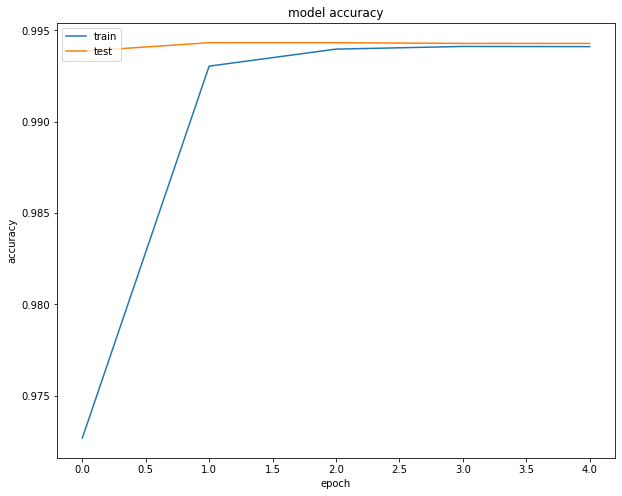

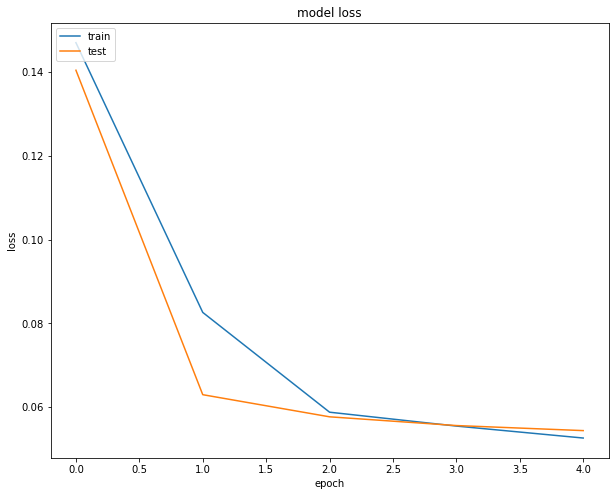

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [112]:
def predict(comment):
    X_new = tokenizer.texts_to_sequences([comment])
    X_new = pad_sequences(X_new, padding='post', maxlen=maxlen)
    new_prediction = model.predict(X_new)
    print('------------------------------------')
    print('Comment: %s\n' % comment)
    for index, label in enumerate(toxic_comments_labels.columns):
        print("  %s: %.2f%%" % (label, (new_prediction[0][index]*100)))
    print('------------------------------------\n')


In [146]:
predict('Bro we have so much in common')

------------------------------------
Comment: Bro we have so much in common

  toxic: 1.87%
  severe_toxic: 0.01%
  obscene: 0.27%
  threat: 0.04%
  insult: 0.32%
  identity_hate: 0.05%
------------------------------------



In [147]:
predict('Lady, I really would rather not fight.')

------------------------------------
Comment: Lady, I really would rather not fight.

  toxic: 2.53%
  severe_toxic: 0.01%
  obscene: 0.35%
  threat: 0.06%
  insult: 0.43%
  identity_hate: 0.07%
------------------------------------



In [152]:
predict("You better stop, sir. No one cares you are a millionaire.")

------------------------------------
Comment: You better stop, sir. No one cares you are a millionaire.

  toxic: 64.09%
  severe_toxic: 0.68%
  obscene: 17.61%
  threat: 1.43%
  insult: 20.15%
  identity_hate: 2.53%
------------------------------------



In [153]:
predict("I am not trying to start a discussion here.")

------------------------------------
Comment: I am not trying to start a discussion here.

  toxic: 1.90%
  severe_toxic: 0.01%
  obscene: 0.27%
  threat: 0.04%
  insult: 0.32%
  identity_hate: 0.05%
------------------------------------



In [157]:
predict("Dude, you can't even do a single push up, just go to sleep or something.")

------------------------------------
Comment: Dude, you can't even do a single push up, just go to sleep or something.

  toxic: 64.58%
  severe_toxic: 0.69%
  obscene: 17.93%
  threat: 1.44%
  insult: 20.43%
  identity_hate: 2.56%
------------------------------------

